# INSEE income data - User validation 

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Local application imports
sys.path.insert(0, '../Utility files')
from utils2 import *

### Using Tim's data

In [2]:
# # Load the data

# path = '/home/livtollanes/NewData/coordinates/dim_X/'
# file = '/m1_dimx_users_bios.csv'
# m1_bios = pd.read_csv(path+file, index_col=0)


# If the job titles have already been collected
path = '/home/livtollanes/NewData/professions/'
file = 'm1_professions.csv'
m1_bios = pd.read_csv(path+file, index_col=0)


In [ ]:
#analyser = tpp.df_bios_analyzer(m1_bios, description_column= 'description_cleantext')
#analyser.get_all(mainfrench='True')
#analyser.get_PCSgroup()


# analyser = tpp.df_bios_analyzer(m1_bios, description_column= 'description_cleantext')
# analyser.get_prostatus()

# #write to csv to avoid rerunning every time
# m1_bios.to_csv('/home/livtollanes/NewData/professions/m1_professions.csv')

In [3]:
#Select only rows where professions is not an empty list
m1_bios_professions = m1_bios[m1_bios['professions'].apply(lambda x: x != "[]")] #removing 87 183 rows

m1_bios_professions.shape #27896
#m1_bios.shape #115 079

(27896, 21)

In [5]:
m1_bios_professions.columns

Index(['follower_id', '0', '1', '2', 'projection', 'screen_name',
       'description_cleantext', 'tokens', 'bi_tokens', 'full_tokens',
       'professions', 'prostatus', 'actorstatus', 'groupstatus',
       'universitystatus', 'allstatus', 'age', 'gender', 'topic', 'lang',
       'PCSgroup'],
      dtype='object')

In [7]:
m1_bios_professions[['screen_name','1', 'professions', 'description_cleantext', 'prostatus']].iloc[0:10]

,screen_name,1,professions,description_cleantext,prostatus
8,degust_harmonie,3.532449,"['animator', 'professor', 'consultant']","Consultant, formateur et animateur en oenologi...",[]
9,MelvynBoukli,3.532449,['ceo'],Directeur Général (CEO) de @EasywaFR ...,"['professional', 'director']"
12,delphine_tweet,3.473119,['human resources'],HR Development #RH #Recrutement #Formation #Co...,[]
17,henri_meisner,3.367104,['human resources'],Je suis convaincu que l'#education est la base...,[]
26,upstifr,3.132626,['engineer'],Union des Professeurs de Sciences et Technique...,[]
46,Smraihi,3.175373,['researcher'],Doctorante sciences de l'éducation - CREADIngé...,['phd']
50,DTAingenierie,3.207863,['analyst'],"ESN spécialisée en dév #informatique, nous acc...",['specialist']
57,c_aubisse,3.167436,['communications manager'],Responsable de la communication scientifique d...,['executive']
64,JFJoanny,3.028496,"['researcher', 'professor']",Chercheur à @institut_curie et professeur @cdf...,[]
78,AMPatard,3.327277,['communications manager'],Directrice Communication et Marque du Pôle Léo...,['director']


In [60]:
filtered_rows = m1_bios_professions[m1_bios_professions['professions'].apply(lambda x: 'consultant' in x)]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
print(filtered_rows.shape)
filtered_rows[['0', 'screen_name', 'description_cleantext', 'professions']].head(20)

(1368, 21)


,0,screen_name,description_cleantext,professions
8,-1.847305,degust_harmonie,"Consultant, formateur et animateur en oenologiechez Dégustation et Harmonie""Mieux analyser le vin pour laisser parler vos émotions""","['animator', 'professor', 'consultant']"
82,-1.680336,B2rGroup,Cabinet Conseil en Recrutement dédié aux passionnés de l'Immobilier et de la Construction,['consultant']
86,-1.645005,B_Capitant,"Directeur d'Unité, responsable de l'offre #RH @mc2igroupe , cabinet de conseil en Systèmes d'Information.","['human resources', 'consultant']"
133,-1.639613,Marine2Pimodan,Consultante mission insertion #thales #recrutement #handicap #inclusion #maintiendanslemploi,['consultant']
143,-1.616854,keapartners,"Cabinet de conseil en stratégie. Entreprise à mission & B Corp.Entreprendre les transformations pour une économie souhaitable, telle est notre raison d'être.",['consultant']
271,-1.530410,jackhell0,Consultant digital & création d'entreprise Fan de l'innovation et des entrepreneurs qui osent Freelance consultant & trainer for entrepreneurs & digital,['consultant']
311,-1.554216,NEURONES,Groupe de #Conseil et de Services Numériques. #ESN #consulting #transformationdigitale #tech #IT #innovation recrutements prévus en 2023 !,['consultant']
342,-1.564641,AMDConsulting1,Le groupe AMD Consulting est une société qui propose des services en ingénierie numérique créée en 2003. #SSII #ESN #Emploi #Informatique #Finance #Assurance,['consultant']
387,-1.580209,Mind7Consulting,Cabinet de #conseil spécialisé dans la #data et la #performance : #bigdata #searchanalytics #process #ESN #scala #spark #team contact@mind7.com,['consultant']
431,-1.480024,IFODcoaching,École des métiers du coaching et de l’accompagnement #coaching #RH #consultant #coach #manager,"['human resources', 'coach', 'consultant']"


In [ ]:
#Filter the DataFrame to only include the users with one title only
m1_single_jobs = m1_bios_professions.loc[m1_bios_professions['professions'].apply(lambda x: len(ast.literal_eval(x)) == 1)]

#Make the format normal style
m1_single_jobs['professions'] = m1_single_jobs['professions'].apply(lambda x: ast.literal_eval(x)[0])
m1_single_jobs['PCSgroup'] = m1_single_jobs['PCSgroup'].apply(lambda x: ast.literal_eval(x)[0])


In [ ]:
#Inspection of specifc job  titles/columns
col = 'blogger'  # replace with the value you're interested in
m1_single_jobs.loc[m1_single_jobs['professions'].apply(lambda x: x == col)].iloc[:, 4:].head()

In [ ]:
m1_single_jobs['professions'].unique #we have 51 unique, single job titles 

#Income test

In [ ]:
#load income data
path = '/home/livtollanes/10.jan-thesis/labeldata/'
file = 'grov_rett.csv'
dtypes = {'income_mois': 'float'}
income = pd.read_csv(path+file, sep=',', dtype=dtypes)

income = income.rename(columns={'data_job_titles': 'professions'})

income['income_mois'] = income['income_mois'].dropna()

income_bios = income_bios = pd.merge(m1_single_jobs, income[['professions', 'income_mois']], on='professions', how='left')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the median of 'projection', its standard deviation, and median of 'income_mois' for each job group
grouped = income_bios.groupby('professions').agg({'projection': ['median', 'std'], 'income_mois': 'median'}).reset_index()

# Sort the jobs by median projection
grouped = grouped.sort_values(('projection', 'median'))

plt.figure(figsize=(10, 12))  # Increase the height of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('projection', 'median')][i], 
                 y=grouped[('income_mois', 'median')][i] + jitter, 
                 xerr=grouped[('projection', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('projection', 'median')][i], 
             grouped[('income_mois', 'median')][i], 
             grouped['professions'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Median Projection')
plt.ylabel('Median Monthly Salary')
plt.title('Median Projection vs Median Monthly Salary by Profession')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = income_bios.groupby('professions').agg({'projection': ['mean', 'std']}).reset_index()

# Sort the jobs by mean projection and reset index
grouped = grouped.sort_values(('projection', 'mean')).reset_index(drop=True)
plt.figure(figsize=(10, 9))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('projection', 'mean')][i], 
                 y=i + jitter, 
                 xerr=grouped[('projection', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('projection', 'mean')][i], 
             i, 
             grouped['professions'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Professions')
plt.title('Mean dimension coordinate by Profession')

# Remove y-axis numbers
plt.yticks([])

plt.show()

### N-grams + frequency analysis

In [2]:
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
bios = pd.read_csv(path+file, index_col=0)

#Sort the df from high to low according to the first dimenion
bios = bios.sort_values(by='0', ascending=False)
#bios['follower_id'].nunique() #115079

#### Obtain the most frequent n-grams in bios

From bios:

In [ ]:
importlib.reload(utils2)
# Usage:
all_descriptions = ' '.join(bios['description_cleantext'])
ngram_freq = utils2.get_ngram_freq(all_descriptions,n=1)


# Get the most common bigrams
#most_common_unigrams = ngram_freq.most_common(4000)

In [ ]:
#Write the ngrams to csv
# importlib.reload(utils2)
# utils2.write_ngrams_to_csv(most_common_unigrams, 'unigrams.csv')
# utils2.write_ngrams_to_csv(most_common_bigrams, 'bigrams.csv')
# utils2.write_ngrams_to_csv(most_common_trigrams, 'trigrams.csv')
# utils2.write_ngrams_to_csv(unigrams_last1000, 'uni_last1000.csv')

### Filter bios based - token matching between our ngram list and the bios

Obs! Once the codes in the ngram file has been updated by PEdro, reload the new file. Certain manual changes below thus has to be removed

In [32]:
#Load the file containing all relevant ngrams
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/'
file = 'titler_lønn.csv'
job_titles = pd.read_csv(path+file, header=0)

#rename columns
job_titles = job_titles.rename(columns={'n_gram': 'token', 'PCS_ESE_code': 'PCS_ESE'})

#Sort job titles alphabetically and drop unnecessary cols
job_titles = job_titles.sort_values('token')
job_titles = job_titles.drop('Salaire moyen en EQTP', axis=1)
job_titles = job_titles.drop('Notes', axis=1)
job_titles = job_titles.drop('count', axis=1)
job_titles = job_titles.drop('ngram', axis=1)


#Replace newline characters in the 'PCS_ESE_name' column
job_titles['PCS_ESE'] = job_titles['PCS_ESE'].replace('\n', ' ', regex=True)
job_titles['PCS_ESE'] = job_titles['PCS_ESE'].str.strip()


#Reformat NA cells 
job_titles['PCS_ESE_name'] = job_titles['PCS_ESE_name'].replace('Na', np.nan)

#Reformat strangely formated text
job_titles.loc[job_titles['PCS_ESE_name'] == 'Serveurs / Serveuses', 'PCS_ESE_name'] = 'Serveurs, commis de restaurant, garçons qualifiés'
job_titles.loc[job_titles['PCS_ESE'] == '56A1', 'PCS_ESE'] = '561b'
# List of values to remove
values_to_remove = ['olympique lyonnais', 'futur', 'ex', 'ancienne', 'ancien', 'professionnelle', 'professionnel', 'freelance', 'amateur', 'former', 'future']

# Remove the rows
job_titles = job_titles[~job_titles['token'].isin(values_to_remove)]


In [33]:
#Load income data

#income
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/'
file = 'INSEE_merged.csv'
income = pd.read_csv(path+file, sep=",")

#make the codes lower case, to match between data sets
income = income.drop(income.columns[0], axis=1)
income['PCS_ESE'] = income['PCS_ESE'].str.lower()
income = income.sort_values('Salaire moyen en EQTP')

In [2]:
#Get the user bios - that later wil get added income
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
bios = pd.read_csv(path+file, index_col=0)

#Sort the df according to the first dimenion
bios = bios.sort_values(by='0', ascending=False)

In [42]:
#Tokenize our bios and save all tokens in a new column
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

bios = utils2.tokenize_bios(bios, stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#code used in work to look for releant titles
# filtered_rows = m1_bios_sorted[m1_bios_sorted['total_n_grams'].apply(lambda x: ('educateur', 'jeunes') in x)]
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# print(filtered_rows.shape)
# filtered_rows[['0', 'screen_name', 'description_cleantext', 'total_n_grams']].iloc[0:20]

(0, 9)


,0,screen_name,description_cleantext,total_n_grams


In [35]:
# Convert n-grams from strings to tuples in order to filter based on our predefined n-gram list
job_titles['titles'] = job_titles['token'].apply(lambda x: tuple(x.split()))

# #Remove all rows where PCS_ESE is NaN. We only want thentitles that currently have an income code 
# job_titles = job_titles[job_titles['PCS_ESE'].notna()]
# job_titles = job_titles[job_titles['PCS_ESE_name'].notna()]

In [53]:
# Create a list of job titles from which we will filter the bios
titles_list = job_titles['titles'].tolist()

# Include only the users that have bios with n_grams occurring in our job title list
filtered_bios = bios[bios['total_n_grams'].apply(lambda x: any(ng in x for ng in titles_list))].copy()

# Add a new column 'titles'
filtered_bios.loc[:, 'titles'] = filtered_bios['total_n_grams'].apply(lambda x: [ng for ng in titles_list if ng in x])

In [56]:
# Split the detected titles into their respective n size
importlib.reload(utils2)
filtered_bios['unigrams_detected'] = filtered_bios['titles'].apply(lambda x: utils2.separate_ngrams(x)['unigrams_detected'])
filtered_bios['bigrams_detected'] = filtered_bios['titles'].apply(lambda x: utils2.separate_ngrams(x)['bigrams_detected'])
filtered_bios['trigrams_detected'] = filtered_bios['titles'].apply(lambda x: utils2.separate_ngrams(x)['trigrams_detected'])

### Add suggested PCS_ESE codes based on INSEE n_grams

In [57]:
#Obtain ngrams on the Insee data

#income
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/'
file = 'INSEE_merged.csv'
income = pd.read_csv(path+file, sep=",")

#make the codes lower case, to match between data sets
income = income.drop(income.columns[0], axis=1)
income['PCS_ESE'] = income['PCS_ESE'].str.lower()
income = income.sort_values('Salaire moyen en EQTP')

In [58]:

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load the French language model
nlp = spacy.load('fr_core_news_sm')


# Apply the function to the 'total_n_grams' column
income['label_processed'] = income['label'].apply(utils2.preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
#Get ngrams
income['ngrams'] = income['label_processed'].apply(lambda x: utils2.get_ngrams(x, 3))

# Convert n-grams to sets when creating the DataFrames
income['ngrams'] = income['ngrams'].apply(lambda x: set(' '.join(tup) for tup in x))
filtered_bios['total_n_grams'] = filtered_bios['total_n_grams'].apply(lambda x: set(' '.join(tup) for tup in x))


# Apply the function to each row in the 'filtered_bios' DataFrame
filtered_bios['suggested_PCS_ESE'] = filtered_bios['total_n_grams'].apply(utils2.find_all_matches, income_df=income)

In [61]:
filtered_bios.columns

Index(['follower_id', '0', '1', '2', 'projection', 'screen_name',
       'description_cleantext', 'description_cleantext_tokens',
       'total_n_grams', 'titles', 'unigrams_detected', 'bigrams_detected',
       'trigrams_detected', 'suggested_PCS_ESE'],
      dtype='object')

In [63]:
filtered_bios.shape

(41015, 14)

### Manual inspection of bios - lower end focus

In [69]:
bios.columns

Index(['follower_id', '0', '1', '2', 'projection', 'screen_name',
       'description_cleantext', 'description_cleantext_tokens',
       'total_n_grams'],
      dtype='object')

#so far, i've looked at the top 700 ones
adter 700, i only included the ones that sounded unique - so the ones that did not mention owrds in our list

In [6]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
bios[['0', 'follower_id', 'screen_name', 'description_cleantext']].iloc[5000:5100]

,0,follower_id,screen_name,description_cleantext
109295,1.562961,2247559753,FrostPlayer,"Luis Enriqué : ""Si une équipe peut nous mettre 4 buts alors on peut leur en mettre 6 avec l'aide de l'arbitre.."""
106286,1.562960,734408245,MaeGameuZe,32 ans Baigne dans les jeux vidéo depuis pitchoune
109103,1.562946,790830293540278272,Archange341,Bienvenue iciendroit sympa : https://urlz.fr/i0SNhttps://urlz.fr/i0SQ
108888,1.562859,1499167418,n_attend,Mon rêve c'était d'être connu en faisant trembler San Siro - #ACMilan #HeatNation #RavensFlock
112008,1.562833,747896821,Potiron_Vert,Supporter des verts !
112072,1.562673,939675719310946304,vallhe10,"19 ans, fan de foot et de l'OM #TeamOM #TeamParieur Fan de #StrangerThings et de l'actrice Isabelle NantySnapchat : vlhermitte1"
106569,1.562664,1031426233,_TacleALaGorge_,Point faible: trop fort.
112132,1.562521,262686512,charloo44,"Auxiliaire de viePetite fille d'agriculteursSupportrice du FC Nantes, abonnée en Loire.Team Déplacements #ActivNantes"
108927,1.562433,142225944,dezphilippe,Rien à déclarer..
112507,1.562430,895736725418385409,sofloer,IDE complètement à l’Ouest . coup de foudre pour l’Andalousie et aussi le Portugal team rando .


### Create income plots

In [11]:
job_titles = job_titles.dropna(subset=['Salaire moyen en EQTP'])
bios_exploded = filtered_bios.explode('titles')

In [14]:
# bios_exploded = filtered_bios.explode('titles')

# # Step 1: Create a list of the specified ngrams
# specified_ngrams = ['amateur', 'ancien', 'ancienne', 'ex', 'futur', 'passé', 'passée']

# # Step 2: Define a function that checks if any of the ngrams in 'titles' occur in 'total_n_grams' together with any of the specified ngrams
# def check_ngrams(row):
#     for ngram in row['titles']:
#         for specified_ngram in specified_ngrams:
#             if (specified_ngram, ngram) in row['total_n_grams']:
#                 return True
#     return False

# # Store the number of rows and unique IDs before filtering
# num_rows_before = bios_exploded.shape[0]
# unique_ids_before = bios_exploded['follower_id'].nunique()  # Replace 'id' with your actual ID column name

# # Step 3: Use the `apply` function to apply this function to each row and create a new column 'to_delete'
# bios_exploded['to_delete'] = bios_exploded.apply(check_ngrams, axis=1)

# # Step 4: Filter out the rows where 'to_delete' is True
# #bios_exploded = bios_exploded[bios_exploded['to_delete'] == False]

# # Store the number of rows and unique IDs after filtering
# num_rows_after = bios_exploded.shape[0]
# unique_ids_after = bios_exploded['follower_id'].nunique()  # Replace 'id' with your actual ID column name

# # Calculate and print the number of rows and unique IDs removed
# num_rows_removed = num_rows_before - num_rows_after
# unique_ids_removed = unique_ids_before - unique_ids_after
# print(f"Number of rows removed: {num_rows_removed}")
# print(f"Number of unique IDs removed: {unique_ids_removed}")

# # Drop the 'to_delete' column as it's no longer needed
# #bios_exploded.drop('to_delete', axis=1, inplace=True)


Number of rows removed: 0
Number of unique IDs removed: 0


In [37]:
bios_exploded = bios_exploded[bios_exploded['titles'] != ('analyste',)]
bios_exploded = bios_exploded[bios_exploded['titles'] != ('rédacteur',)]
bios_exploded = bios_exploded[bios_exploded['titles'] != ('rédactrice',)]
bios_exploded = bios_exploded[bios_exploded['titles'] != ('reporter images',)]
bios_exploded = bios_exploded[bios_exploded['titles'] != ('secrétaire',)]

bios_exploded = bios_exploded[bios_exploded['titles'] != ('médecin santé publique',)]
bios_exploded = bios_exploded[bios_exploded['titles'] != ('médecin éducation nationale',)]
bios_exploded = bios_exploded[bios_exploded['titles'] != ('médecin du sport',)]
bios_exploded = bios_exploded[bios_exploded['titles'] != ('secrétaire',)]

In [100]:
duplicated_rows = bios_exploded[bios_exploded.duplicated('follower_id', keep=False)]
duplicated_rows.iloc[0:3] #9082 rows

,follower_id,0,1,2,projection,screen_name,description_cleantext,description_cleantext_tokens,total_n_grams,titles,unigrams_detected,bigrams_detected,trigrams_detected
114862,983513406257934336,2.021421,1.019015,-1.878439,-2.322631,HassaneDjibrils,"Étudie à l’Institut Supérieur de Formation au Journalisme et à la Communication ( ISFJ ) à Lyon. Journaliste Reporter à @Foot224, passionné du sport roi.","[étudie, institut, supérieur, formation, journalisme, communication, isfj, lyon, journaliste, reporter, passionné, sport, roi]","[(étudie,), (institut,), (supérieur,), (formation,), (journalisme,), (communication,), (isfj,), (lyon,), (journaliste,), (reporter,), (passionné,), (sport,), (roi,), (étudie, institut), (institut, supérieur), (supérieur, formation), (formation, journalisme), (journalisme, communication), (communication, isfj), (isfj, lyon), (lyon, journaliste), (journaliste, reporter), (reporter, passionné), (passionné, sport), (sport, roi), (étudie, institut, supérieur), (institut, supérieur, formation), (supérieur, formation, journalisme), (formation, journalisme, communication), (journalisme, communication, isfj), (communication, isfj, lyon), (isfj, lyon, journaliste), (lyon, journaliste, reporter), (journaliste, reporter, passionné), (reporter, passionné, sport), (passionné, sport, roi)]","(journaliste,)","[(journaliste,), (reporter,)]",[],[]
114862,983513406257934336,2.021421,1.019015,-1.878439,-2.322631,HassaneDjibrils,"Étudie à l’Institut Supérieur de Formation au Journalisme et à la Communication ( ISFJ ) à Lyon. Journaliste Reporter à @Foot224, passionné du sport roi.","[étudie, institut, supérieur, formation, journalisme, communication, isfj, lyon, journaliste, reporter, passionné, sport, roi]","[(étudie,), (institut,), (supérieur,), (formation,), (journalisme,), (communication,), (isfj,), (lyon,), (journaliste,), (reporter,), (passionné,), (sport,), (roi,), (étudie, institut), (institut, supérieur), (supérieur, formation), (formation, journalisme), (journalisme, communication), (communication, isfj), (isfj, lyon), (lyon, journaliste), (journaliste, reporter), (reporter, passionné), (passionné, sport), (sport, roi), (étudie, institut, supérieur), (institut, supérieur, formation), (supérieur, formation, journalisme), (formation, journalisme, communication), (journalisme, communication, isfj), (communication, isfj, lyon), (isfj, lyon, journaliste), (lyon, journaliste, reporter), (journaliste, reporter, passionné), (reporter, passionné, sport), (passionné, sport, roi)]","(reporter,)","[(journaliste,), (reporter,)]",[],[]
114833,458303283,2.020014,0.999803,-1.856934,-2.317603,ATofficiel,Journaliste à dominante ovale - auteur d'Adieu Champions et fondateur du podcast En Terrain Conquishttps://feed.ausha.co/vpkvvimejqr8,"[journaliste, dominante, ovale, auteur, champions, fondateur, podcast, terrain, conquis]","[(journaliste,), (dominante,), (ovale,), (auteur,), (champions,), (fondateur,), (podcast,), (terrain,), (conquis,), (journaliste, dominante), (dominante, ovale), (ovale, auteur), (auteur, champions), (champions, fondateur), (fondateur, podcast), (podcast, terrain), (terrain, conquis), (journaliste, dominante, ovale), (dominante, ovale, auteur), (ovale, auteur, champions), (auteur, champions, fondateur), (champions, fondateur, podcast), (fondateur, podcast, terrain), (podcast, terrain, conquis)]","(auteur,)","[(auteur,), (journaliste,)]",[],[]


In [50]:
bios_exploded = bios_exploded.drop_duplicates('follower_id', keep='first')

# Convert all titles to lowercase
job_titles['titles'] = job_titles['titles'].apply(lambda x: tuple([i.lower() for i in x]))
bios_exploded['titles'] = bios_exploded['titles'].apply(lambda x: tuple([i.lower() for i in x]))

bios_exploded = bios_exploded.merge(job_titles, on='titles', how='left')

In [82]:
grouped = bios_exploded.groupby('token').agg({'0': ['mean', 'std']}).reset_index()

grouped.head()

token         0          
                        mean       std
0           acteur -0.226071  0.598517
1          actrice -0.129062  0.642245
2    adjoint maire -0.320737  0.351368
3   adjointe maire -0.382505  0.231577
4  agent assurance -0.163924       NaN

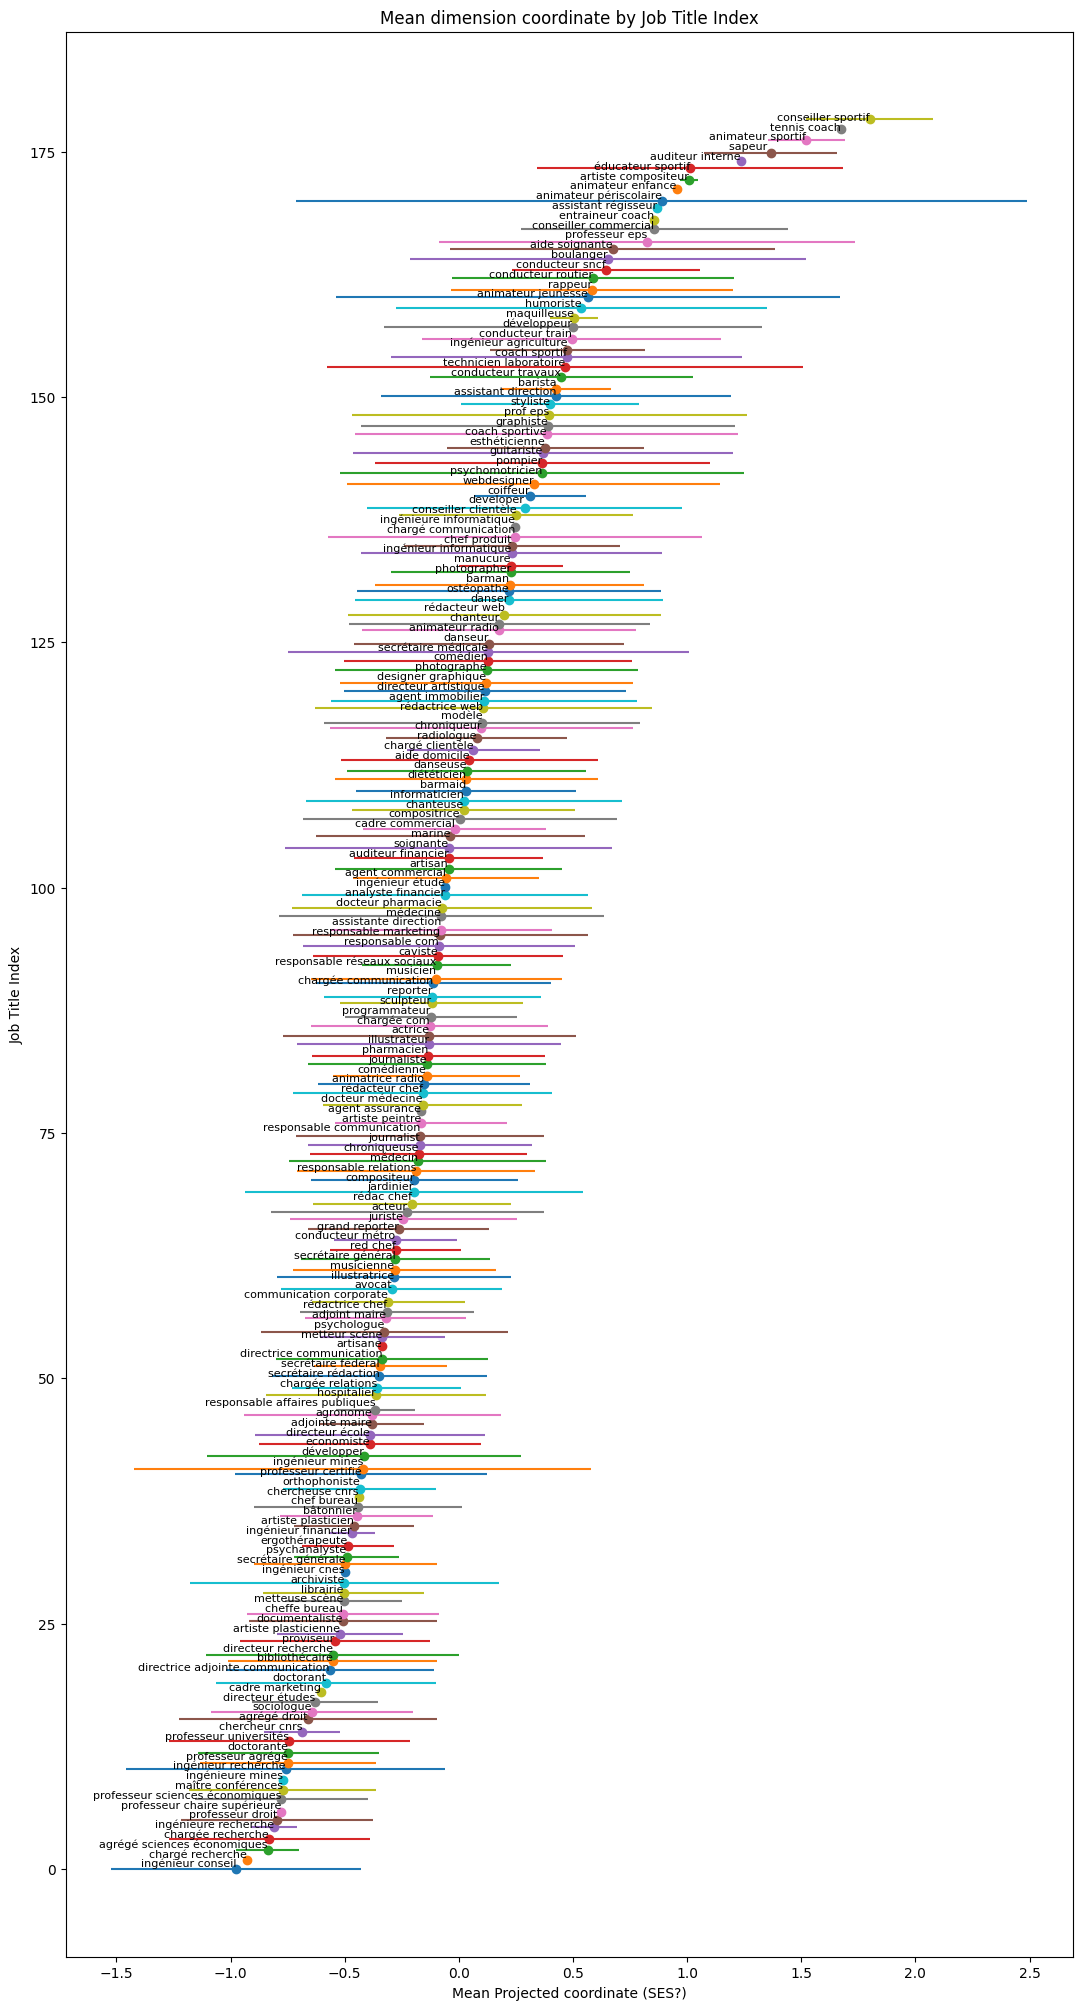

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = bios_exploded.groupby('token').agg({'0': ['mean', 'std'], 'PCS_ESE_class': 'first'}).reset_index()

# Sort the jobs by the mean SES and reset index
grouped = grouped.sort_values(('0', 'mean')).reset_index(drop=True)
plt.figure(figsize=(13, 25))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('0', 'mean')][i], 
                 y=i + jitter, 
                 xerr=grouped[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point with reduced text size
for i in range(grouped.shape[0]):
    plt.text(grouped[('0', 'mean')][i], 
             i, 
             grouped['token'][i], 
             ha = 'right', va = 'bottom', fontsize=8)  # Adjust fontsize as needed

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Job Title Index')
plt.title('Mean dimension coordinate by Job Title Index')

plt.show()

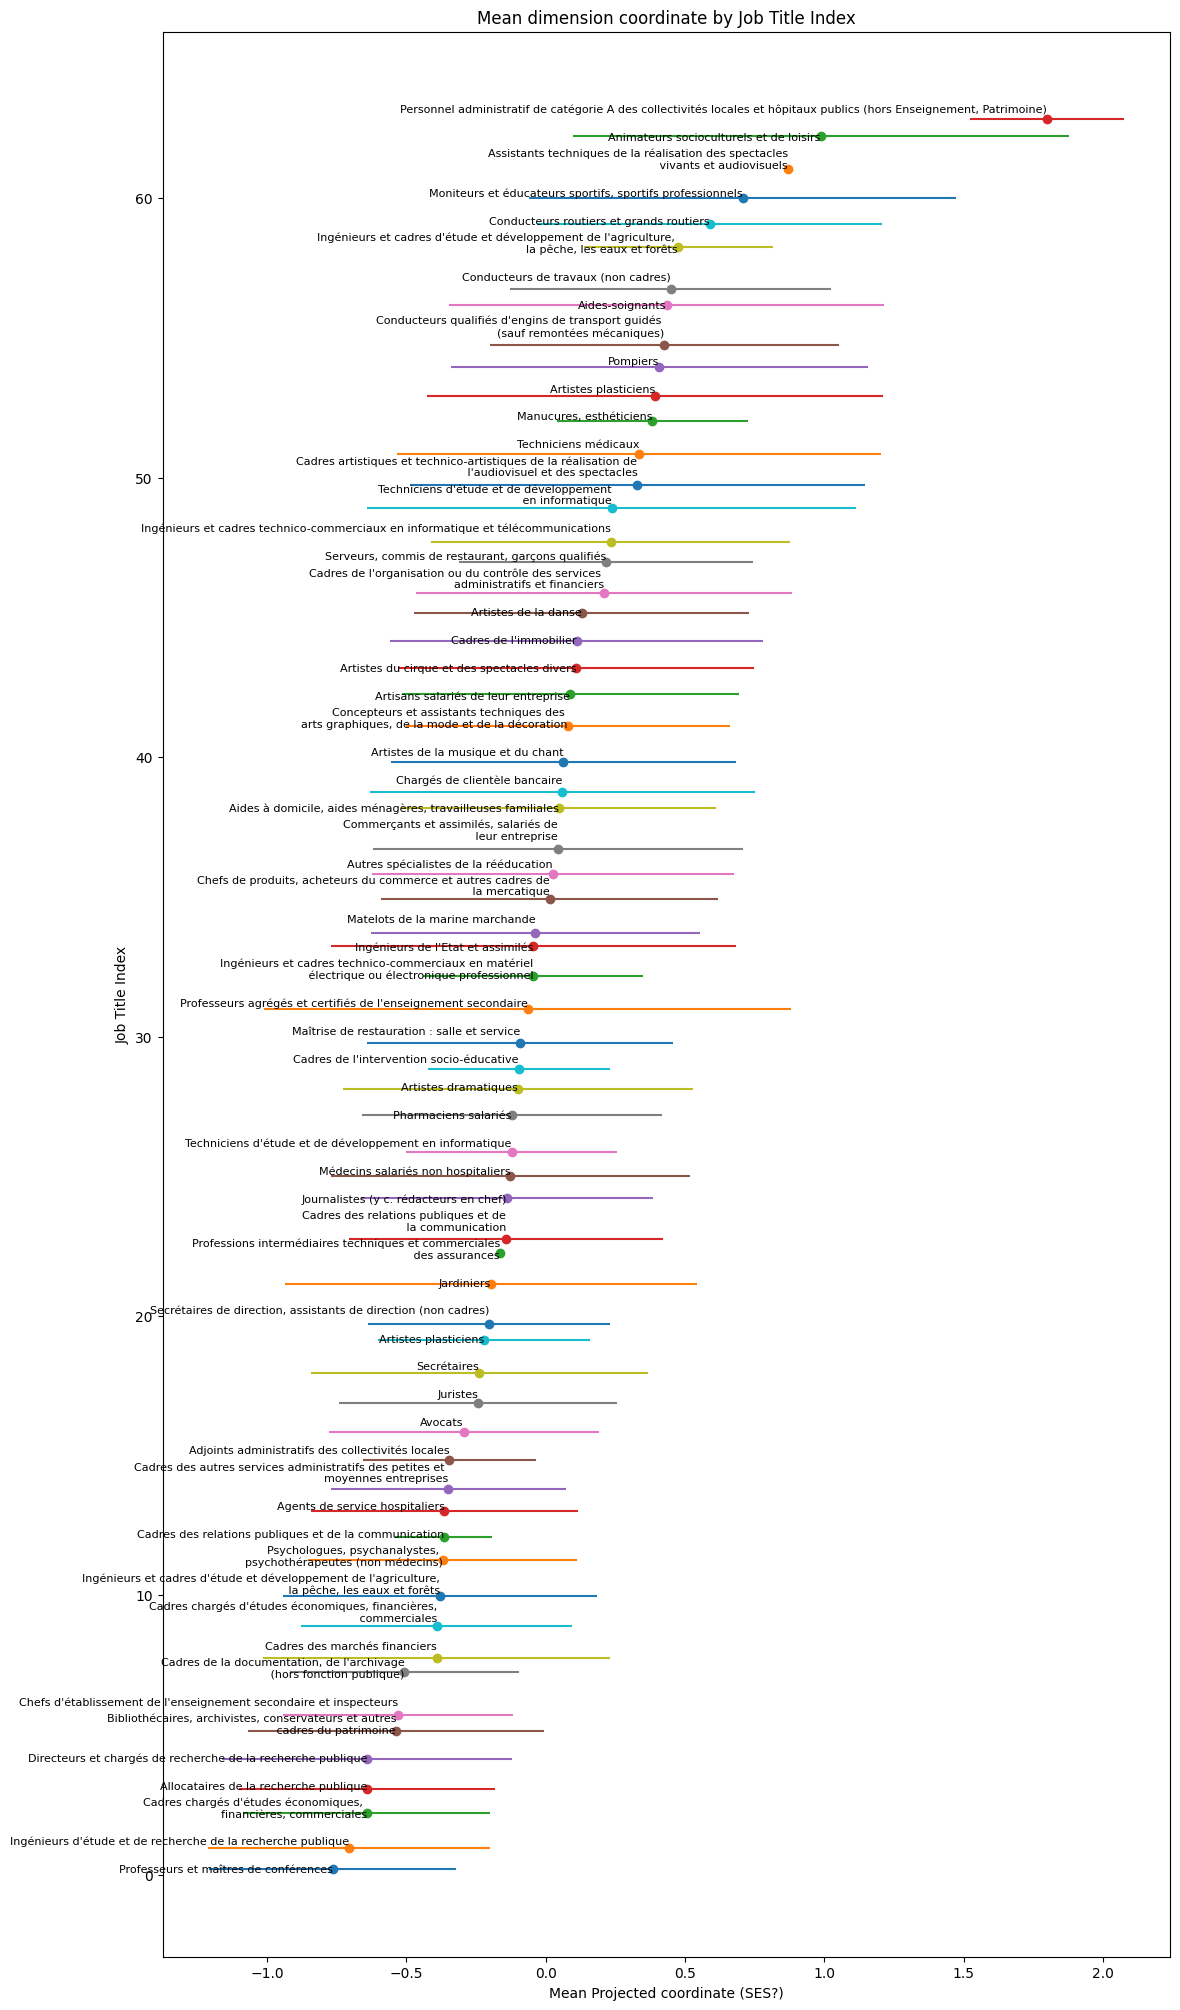

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = bios_exploded.groupby('PCS_ESE_name').agg({'0': ['mean', 'std'], 'PCS_ESE_class': 'first'}).reset_index()

# Sort the jobs by the mean SES and reset index
grouped = grouped.sort_values(('0', 'mean')).reset_index(drop=True)
plt.figure(figsize=(13, 25))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('0', 'mean')][i], 
                 y=i + jitter, 
                 xerr=grouped[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point with reduced text size
for i in range(grouped.shape[0]):
    plt.text(grouped[('0', 'mean')][i], 
             i, 
             grouped['PCS_ESE_name'][i], 
             ha = 'right', va = 'bottom', fontsize=8)  # Adjust fontsize as needed

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Job Title Index')
plt.title('Mean dimension coordinate by Job Title Index')

plt.show()

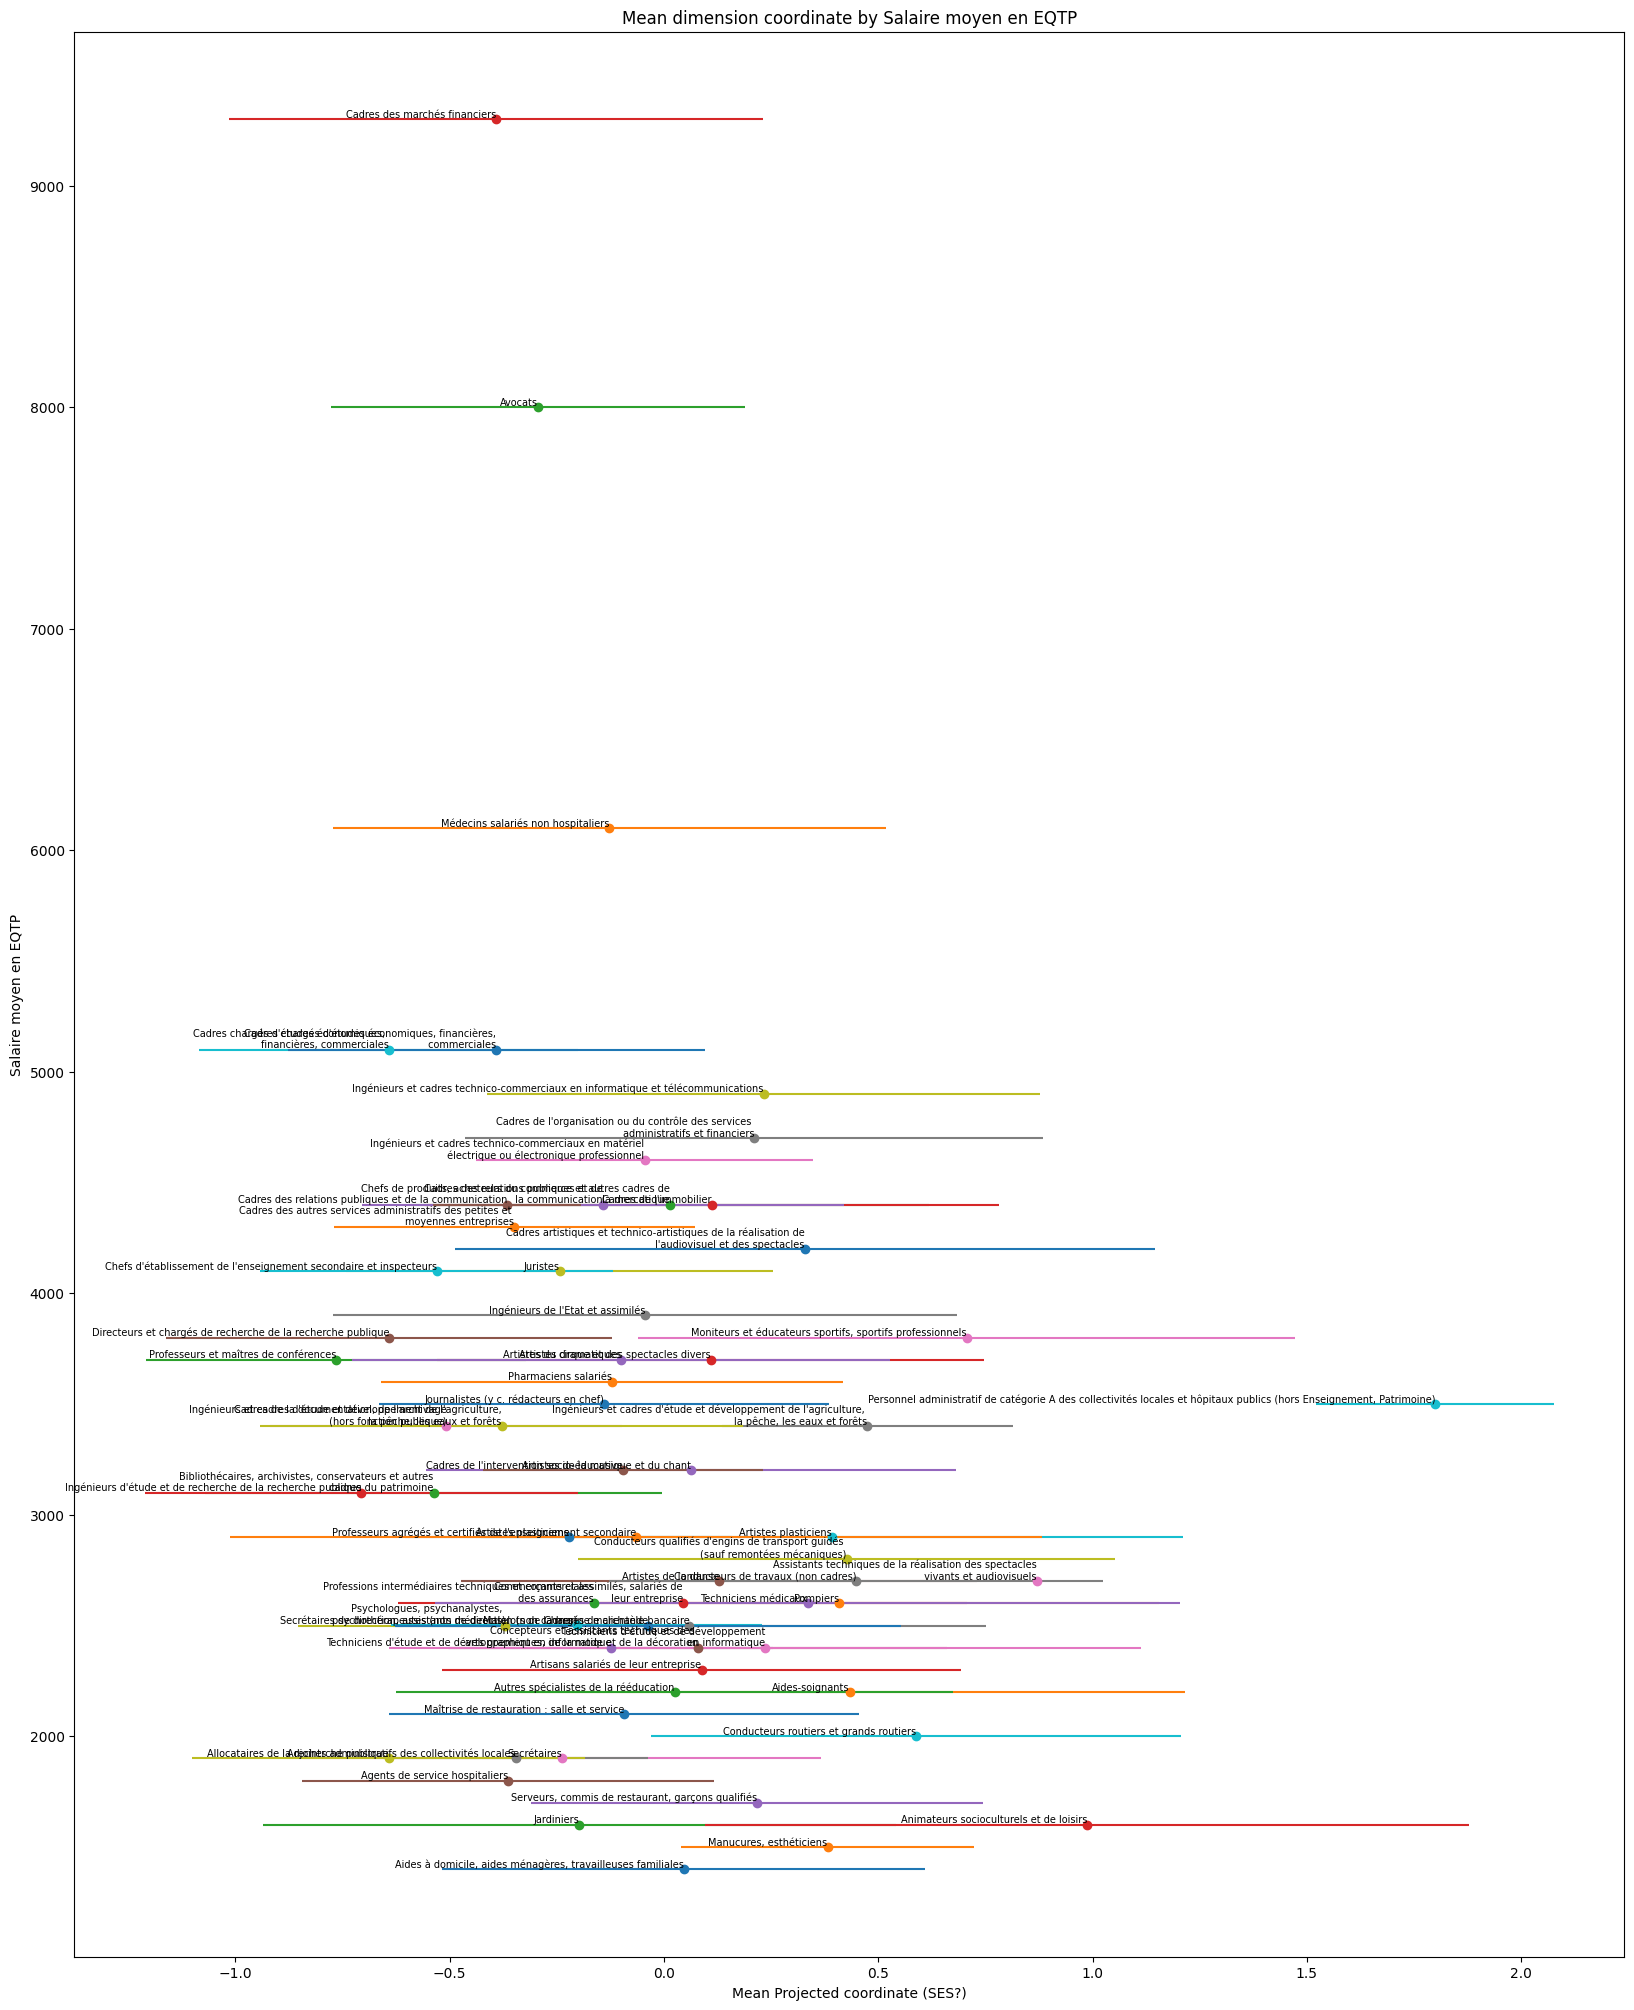

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = bios_exploded.groupby('PCS_ESE_name').agg({'0': ['mean', 'std'], 'Salaire moyen en EQTP': 'first'}).reset_index()

# Sort the jobs by 'Salaire moyen en EQTP' and reset index
grouped = grouped.sort_values(('Salaire moyen en EQTP', 'first')).reset_index(drop=True)
plt.figure(figsize=(20, 25))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('0', 'mean')][i], 
                 y=grouped[('Salaire moyen en EQTP', 'first')][i] + jitter, 
                 xerr=grouped[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point with reduced text size
for i in range(grouped.shape[0]):
    plt.text(grouped[('0', 'mean')][i], 
             grouped[('Salaire moyen en EQTP', 'first')][i], 
             grouped['PCS_ESE_name'][i], 
             ha = 'right', va = 'bottom', fontsize=7)  # Adjust fontsize as needed

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Salaire moyen en EQTP')
plt.title('Mean dimension coordinate by Salaire moyen en EQTP')

plt.show()

In [118]:
x = bios_exploded[bios_exploded['PCS_ESE_name'] == 'Personnel administratif de catégorie A des collectivités locales et hôpitaux publics (hors Enseignement, Patrimoine)']
pd.set_option('display.max_colwidth', None)
x[['screen_name', 'projection', 'description_cleantext', 'titles','unigrams_detected', 'bigrams_detected', 'trigrams_detected']].iloc[0:12]

,screen_name,projection,description_cleantext,titles,unigrams_detected,bigrams_detected,trigrams_detected
9,melinjerome,-2.326592,"Conseiller Sportif dans le football, superviseur free-lance, passionné de foot et de sport...","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
17,FutureFootbal16,-2.322631,Agent de Joueurs de Football Gestion de Carrière Conseiller Sportif,"(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
20,soccer_antoine,-2.321397,"Conseiller Sportif. .................« No pain, no gain »","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
26,marinnicolas_16,-2.211545,"Ancien Joueur Professionnel de Football , aujourd’hui Conseiller Sportif","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
44,Kevin_Konrad11,-2.127862,Conseiller Sportif. Passionné de foot (Amiens SC / PSG).,"(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
99,Peyretben,-2.072327,"@AGMS, conseiller sportif, communication, marketing","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
277,33NEOKORTEX,-1.838784,"Entrepreneur, conseiller sportif spécialisé dans le Football, mais pas que. Votre interprétation de mes tweets n'engage que vous.","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
415,MekhaldiHedi,-1.697272,"Team SGM sport ( with @govousidney ) conseiller sportif pour les footballeurs professionnels, spécialiste management, communication, marketing.","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
647,LoicLecoq7,-1.338474,Scout et conseiller sportif en Ile de France Specialiste N2-N3,"(conseiller, sportif)",[],"[(conseiller, sportif)]",[]


In [88]:
grouped

token         0            \
                                            mean       std   
0                        aide domicile  0.045984  0.564159   
1                        esthéticienne  0.379110  0.431971   
2                          maquilleuse  0.503914  0.103847   
3                             manucure  0.227777  0.228423   
4                    animateur enfance  0.954342       NaN   
5                            jardinier -0.196924  0.739179   
6                    animateur sportif  1.522271  0.169433   
7               animateur périscolaire  0.889229  1.601160   
8                   animateur jeunesse  0.567077  1.104068   
9                               barman  0.221853  0.589261   
10                             barista  0.427430  0.239876   
11                             barmaid  0.031241  0.481758   
12                         hospitalier -0.363437  0.480145   
13                 secrétaire médicale  0.129054  0.877013   
14                secrétaire rédaction -0.348158  0.472354   
15                          doctorante -0.747178  0.396485   
16                      adjointe maire -0.382505  0.231577   
17                           doctorant -0.581969  0.480453   
18                       adjoint maire -0.320737  0.351368   
19                  conducteur routier  0.588199  0.617970   
20                             caviste -0.092210  0.548506   
21                           soignante -0.044751  0.715796   
22                     psychomotricien  0.363649  0.884222   
23                       orthophoniste -0.434525  0.333757   
24                      ergothérapeute -0.485552  0.199476   
25                          ostéopathe  0.218835  0.666949   
26                      aide soignante  0.673257  0.710571   
27                         diététicien  0.032984  0.574626   
28                            coiffeur  0.313386  0.245212   
29                            artisane -0.335682       NaN   
30                             artisan -0.045381  0.496101   
31                           boulanger  0.653722  0.866516   
32                           developer  0.288245  0.691125   
33                  designer graphique  0.119099  0.642008   
34                       programmateur -0.122659  0.378222   
35                          développer -0.415416  0.686262   
36                         développeur  0.499191  0.827928   
37                            styliste  0.400338  0.389480   
38                        illustrateur -0.130254  0.578585   
39                       illustratrice -0.284838  0.511933   
40                       psychanalyste -0.491701  0.230237   
41                         chef bureau -0.441572  0.455718   
42                         psychologue -0.326833  0.540512   
43                              marine -0.036873  0.589392   
44                  secrétaire fédéral -0.345312  0.291395   
45               conseiller commercial  0.855957  0.584998   
46                    chargé clientèle  0.063772  0.291193   
47                       cheffe bureau -0.507622  0.419397   
48                assistante direction -0.077510  0.487335   
49                conseiller clientèle  0.251160  0.513077   
50                 assistant direction  0.426104  0.765448   
51                         photographe  0.121221  0.664645   
52                             pompier  0.366098  0.734088   
53                        photographer  0.227445  0.524032   
54                           librairie -0.504990  0.353890   
55              technicien laboratoire  0.463926  1.041997   
56                          radiologue  0.077534  0.397530   
57                     agent assurance -0.163924       NaN   
58                             sapeur   1.365485  0.291639   
59                            danseuse  0.035111  0.523807   
60                  conducteur travaux  0.448633  0.575918   
61                             danseur  0.130579  0.592119   
62                              danser  0.218475  0.674979   
63 

In [2]:
import numpy as np
import os
import matplotlib
import pandas as pd

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import importlib

import sys
# # Local application imports
# sys.path.insert(0, '../Utility files')
# import utils2
# from utils2 import *

In [4]:
#Get the user bios - that later wil get added income
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
df = pd.read_csv(path+file, index_col=0)

#Sort the df according to the first dimenion
df = df.sort_values(by='0', ascending=False)

In [21]:
import pandas as pd



# Regex pattern to match URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Filter rows where the bio contains a URL
url_bios = df[df['description_cleantext'].str.contains(url_pattern, na=False, regex=True)]
linkedin_bios = url_bios[url_bios['description_cleantext'].str.contains('linkedin', na=False, case=False)]

In [25]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
linkedin_bios

,follower_id,0,1,2,projection,screen_name,description_cleantext
110707,2264208407,1.613579,0.617701,-0.058194,-1.562009,Perez_S7,Responsable de Rayon @Decathlon - Ex @SportfiveFR - @SportMarket_fr & @MontpelEvents - Passionné de #Sport #SportBusiness - https://www.linkedin.com/profile/view?id318716164
110960,3802549216,1.528221,0.516361,-0.574804,-1.590691,m_leperque,Product Owner @panorabanques Respo comm @LigueRecruteurs #AllForOne #NBAFan Cuisto amateur #i4emploi http://bit.ly/LinkedInMLep
103758,2287271485,1.404488,0.499619,1.199399,-1.100636,instaply_fr,Nous postons régulièrement sur https://www.linkedin.com/company/instaply
108431,2147655175,1.315352,0.455734,-0.510604,-1.371939,LeSportBiz,Actualités et coulisses Offres d'emploi sur Linkedin Podcast http://bit.ly/3LVYMnM contact@lesportbusiness.com ou message privé
101573,742354601333141504,1.165949,0.233438,0.696692,-0.983878,_AlexFreedom_,"Divertir, Lire & Découvrir. Pour le reste, Contact Pro' : - http://bit.ly/_Linkedin_ - http://bit.ly/_Viadéo_ #Web #SocialMedia"
99941,1093904072007135232,1.089360,0.296829,0.758326,-0.893455,Aliscom_75,Votre partenaire pour une distribution innovante. #distribution #tech #innovation Page LinkedIn pour suivre notre actualité : http://linkedin.com/company/aliscom
102162,18598350,1.074443,0.293168,0.099488,-1.016391,gillessimon,mes tweets n’engagent que moi http://linkedin.com/in/gillessimon
99251,2607438710,1.072686,0.227810,0.887238,-0.853272,yanisleroy,"Passionné d'informatique, des nouvelles technos... Ingénieur Systèmes et Réseaux - Rédacteur à @liveboxmag et @bboxmag - http://linkedin.com/in/yanis-leroy"
96604,732129238946615296,1.019957,0.180039,1.298923,-0.717990,ScreenbaseDOOH,Agence full #DOOH services. Vous voyez du potentiel dans le DOOH? ca tombe bien nous aussi ! #AdTech #MediaLinkedin : https://tinyurl.com/ya68t4p9
94441,1042358542022270976,0.896530,0.367838,1.179746,-0.614120,olivier_foll,"@sturian1, conseil, gestion de projets IT, digitalisation, organisation et performances#ITSM #ITIL #Prince2http://fr.linkedin.com/in/olivier-le-..."


In [22]:
linkedin_bios.shape

(149, 7)